In [1]:
import torch
from torch import nn
import torchvision
import presets
import numpy as np
import calibration_utils

from torchvision.transforms.functional import InterpolationMode
from sklearn.metrics import  confusion_matrix
from matplotlib import pyplot as plt

In [2]:
device = 'cpu'
MODEL = 'mobilenet_v3_large'
NUM_CLASSES = 2
PATH = 'output/model_8.pth'

model = torchvision.models.get_model(MODEL, weights=None, num_classes=NUM_CLASSES)
state_dict = torch.load(PATH)
model.load_state_dict(state_dict['model'])
model.to(device)
None

In [3]:
args = state_dict["args"]
valdir = "data/val"
interpolation = InterpolationMode(args.interpolation)

In [4]:
preprocessing = presets.ClassificationPresetEval(
                crop_size=args.val_crop_size,
                resize_size=args.val_resize_size,
                interpolation=interpolation,
                backend=args.backend,
                use_v2=args.use_v2,
            )

dataset_test = torchvision.datasets.ImageFolder(
    valdir,
    preprocessing,
)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)
data_loader = torch.utils.data.DataLoader(
        dataset_test, batch_size=args.batch_size, sampler=test_sampler, num_workers=args.workers, pin_memory=True
    )

In [5]:
criterion = nn.CrossEntropyLoss()

conf_scores, preds, gt = list(), list(), list()
with torch.inference_mode():
    for image, target in data_loader:
        image = image.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        output = model(image)
        # loss = criterion(output, target)
        conf_scores.append(torch.nn.functional.softmax(output, dim=1))
        preds.append(torch.argmax(output, dim=1))
        gt.append(target)

In [6]:
np_gt = np.concatenate([x.numpy() for x in gt])
np_pred = np.concatenate([x.numpy() for x in preds])
np_conf = np.concatenate([x[:,0].numpy() for x in conf_scores])
print(f"Ground Truth: {np_gt.shape}\t{min(np_gt)}\t{max(np_gt)}"\
      f"\nPrediction: {np_pred.shape}\t{min(np_pred)}\t{max(np_pred)}"\
      f"\nConfidence: {np_conf.shape}\t{min(np_conf):.3f}\t{max(np_conf):.3f}")

Ground Truth: (379,)	0	1
Prediction: (379,)	0	1
Confidence: (379,)	0.000	1.000


Confusion matrix, without normalization
[[257  47]
 [ 51  24]]


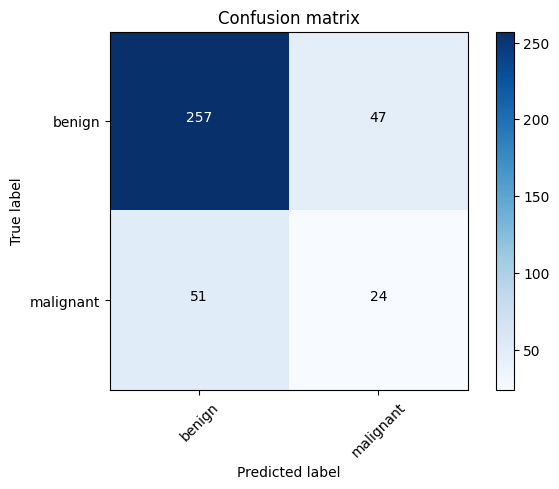

In [7]:
calibration_utils.plot_confusion_matrix(confusion_matrix(np_gt, np_pred), ["benign", "malignant"])
# pprint(confusion_matrix(np_gt, np_pred))

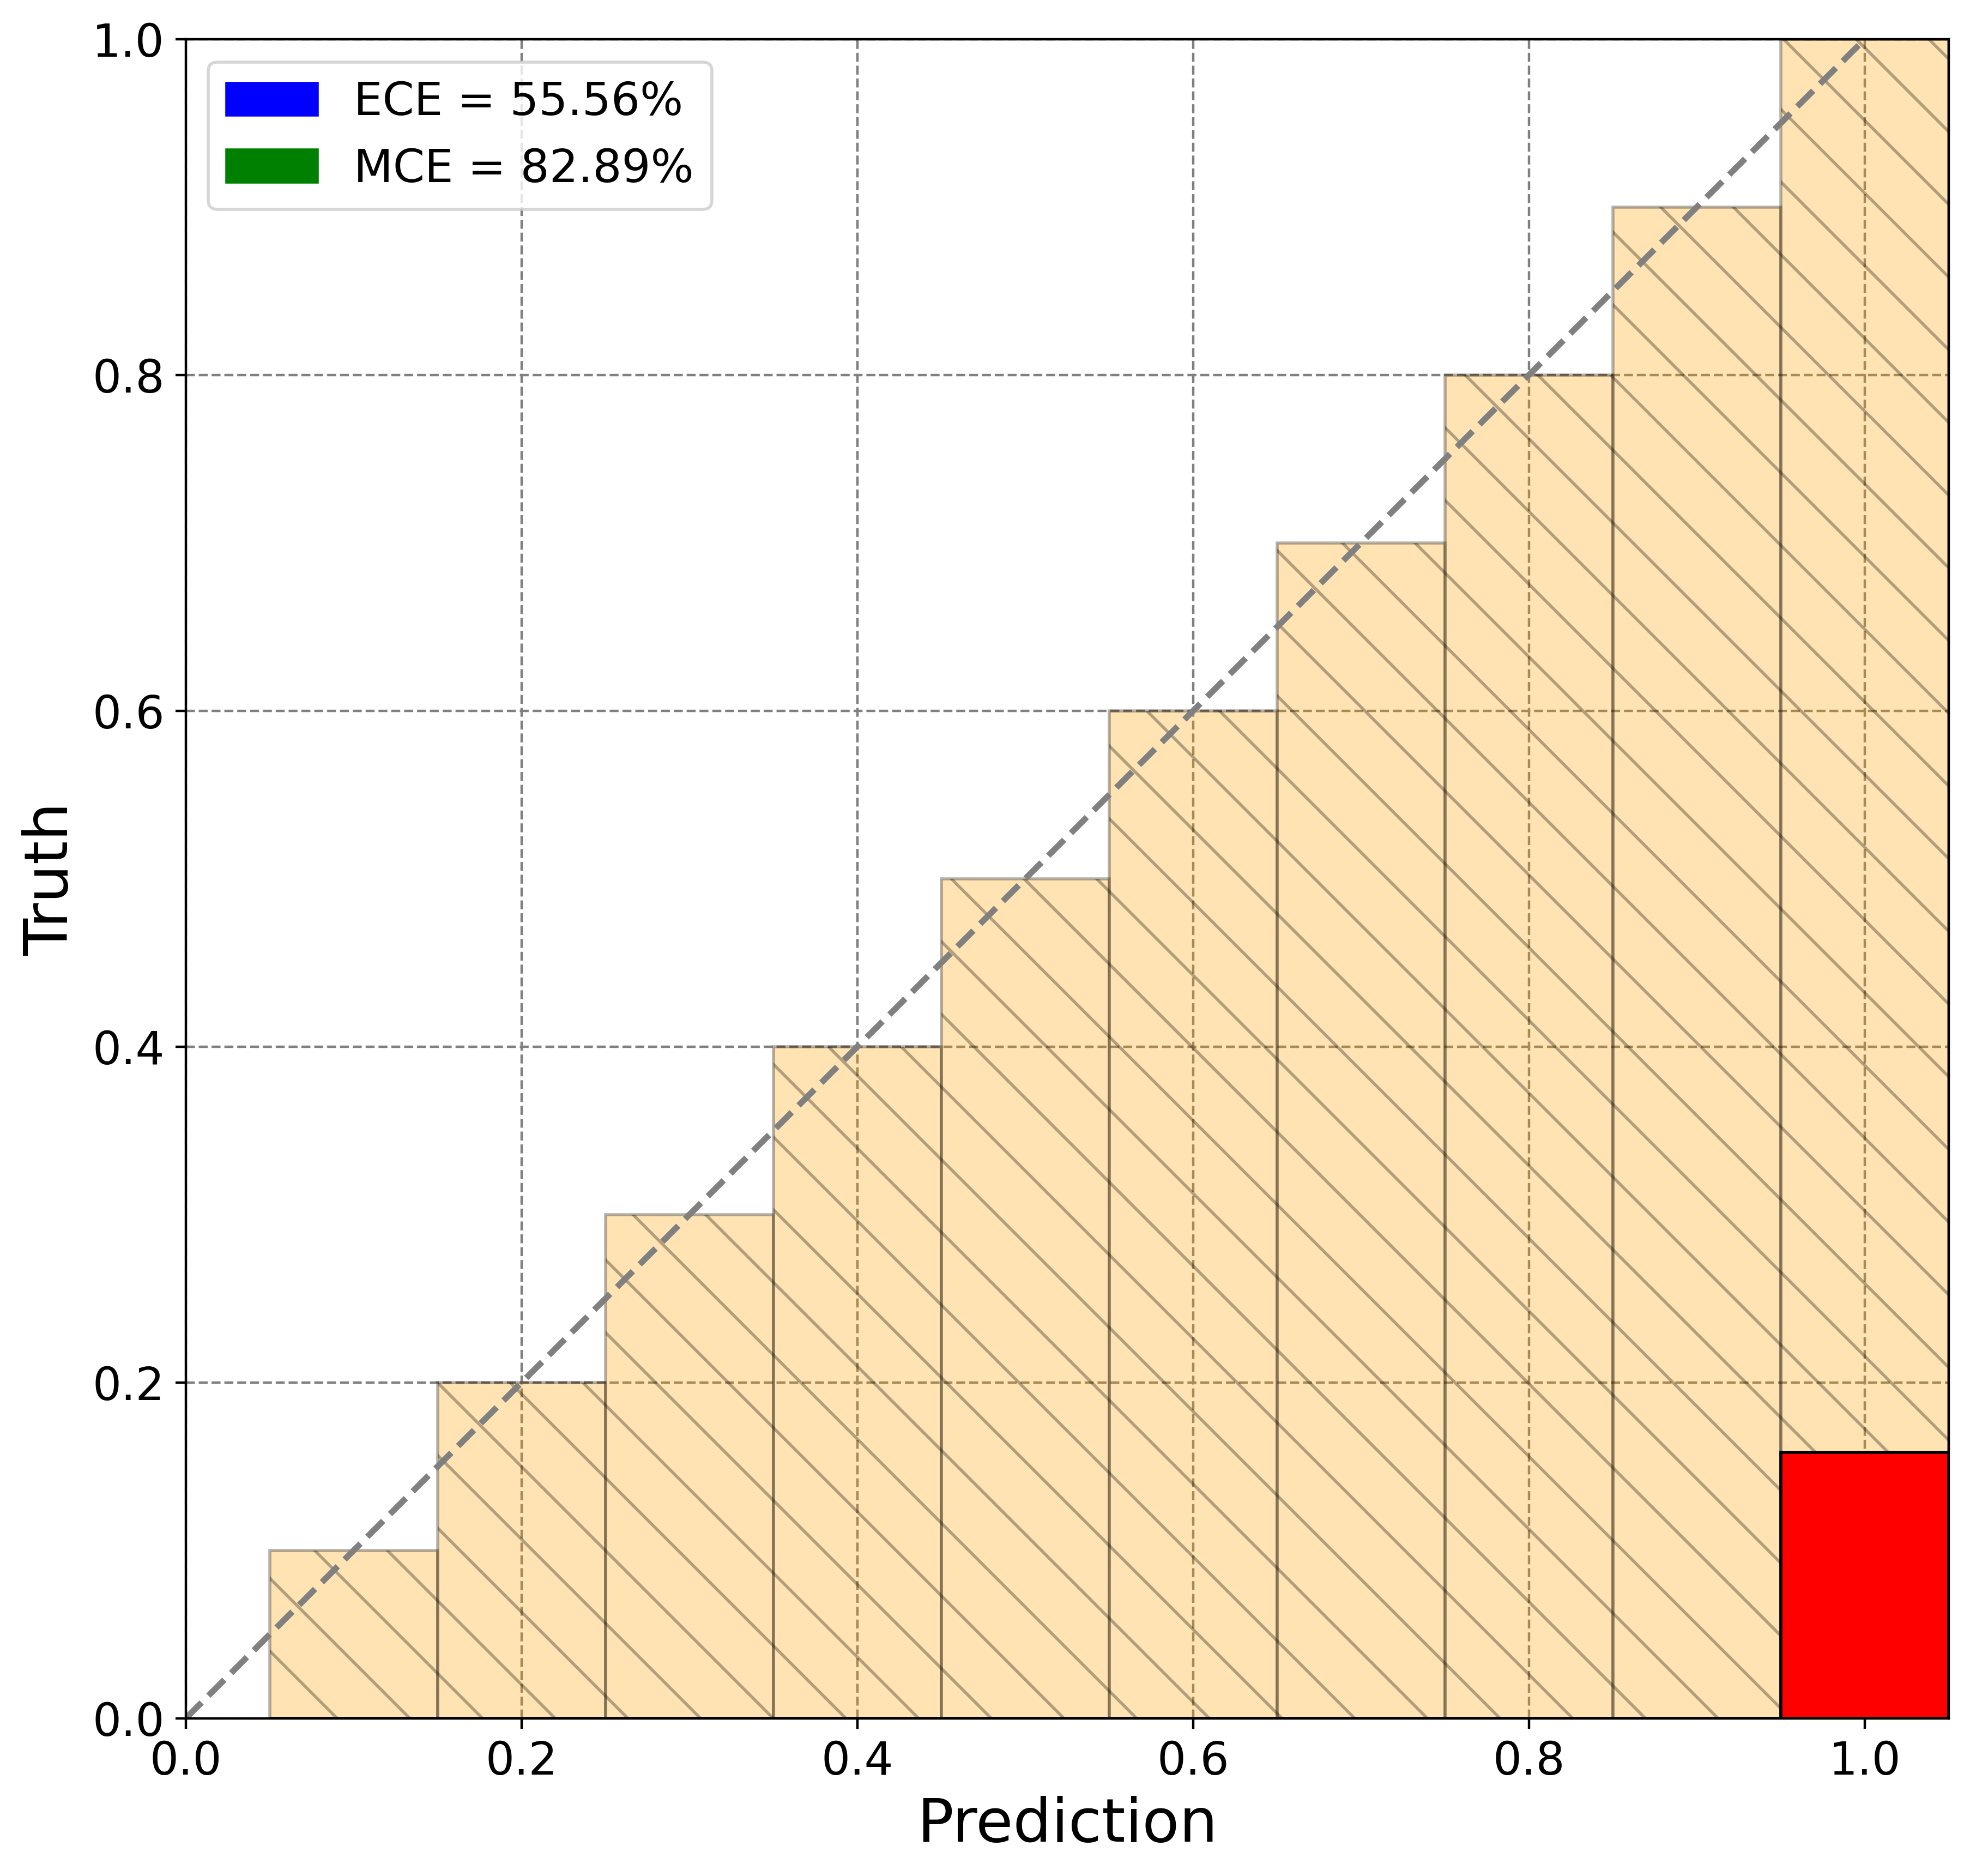

In [38]:
calibration_utils.draw_reliability_graph(np_gt, np_conf)

71


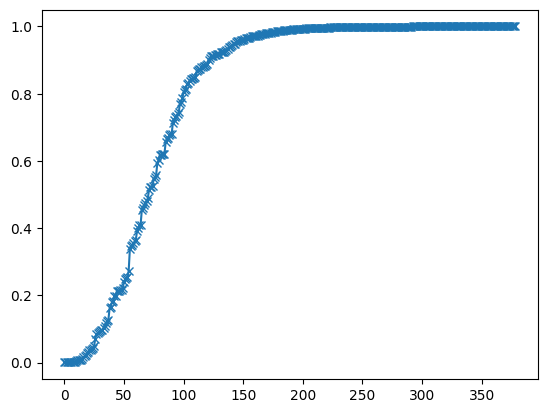

In [9]:
conf_sort = np.sort(np_conf)
print(np.sum((np_conf < 0.5)))
plt.plot(conf_sort, marker='x')
plt.show()
plt.close()

In [10]:
metrics = calibration_utils.matrix_metrix(np_gt, np_pred, 1.0)
# pprint(metrics)

In [11]:
bins, binned, bin_accs, bin_confs, bin_sizes = calibration_utils.calc_bins(np_gt, np_conf)

In [15]:
np_gt.shape

(379,)

In [28]:
np.hstack((np_gt.reshape((-1, 1)), np_conf.reshape((-1, 1)))).shape

(379, 2)

In [39]:
bin_accs

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15853659])

In [37]:
np_gt_and_conf = np.hstack((np_gt.reshape((-1, 1)), np_conf.reshape((-1, 1))))
sorted_index = np.argsort(np_conf)
for row in np_gt_and_conf[sorted_index, :]:
    print(f"{row[0]:.0f} | {row[1]:.2f}")

1 | 0.00
0 | 0.00
0 | 0.00
1 | 0.00
1 | 0.00
0 | 0.00
0 | 0.00
0 | 0.00
0 | 0.00
0 | 0.00
0 | 0.01
0 | 0.01
0 | 0.01
1 | 0.01
1 | 0.01
0 | 0.01
0 | 0.02
0 | 0.02
0 | 0.02
1 | 0.03
1 | 0.03
0 | 0.04
1 | 0.04
0 | 0.04
0 | 0.04
0 | 0.05
0 | 0.07
1 | 0.09
0 | 0.09
0 | 0.09
0 | 0.09
1 | 0.10
0 | 0.10
0 | 0.10
1 | 0.11
0 | 0.12
0 | 0.12
1 | 0.13
0 | 0.16
1 | 0.17
1 | 0.18
0 | 0.18
0 | 0.20
0 | 0.20
0 | 0.21
0 | 0.21
0 | 0.21
0 | 0.21
0 | 0.22
0 | 0.22
0 | 0.24
0 | 0.25
0 | 0.25
0 | 0.25
1 | 0.27
1 | 0.34
0 | 0.35
0 | 0.35
1 | 0.36
1 | 0.36
1 | 0.37
0 | 0.39
0 | 0.40
0 | 0.41
1 | 0.41
1 | 0.45
1 | 0.46
0 | 0.47
0 | 0.47
1 | 0.48
1 | 0.49
1 | 0.51
1 | 0.52
0 | 0.52
0 | 0.52
0 | 0.55
0 | 0.55
0 | 0.56
0 | 0.59
0 | 0.60
0 | 0.62
0 | 0.62
0 | 0.62
1 | 0.62
1 | 0.62
1 | 0.66
0 | 0.66
0 | 0.67
0 | 0.68
0 | 0.68
0 | 0.68
0 | 0.71
0 | 0.72
0 | 0.73
0 | 0.73
0 | 0.74
0 | 0.75
0 | 0.77
0 | 0.78
0 | 0.79
0 | 0.80
0 | 0.81
0 | 0.82
0 | 0.83
0 | 0.83
0 | 0.84
0 | 0.84
0 | 0.84
0 | 0.85
0 | 0.85
1 | 0.85
0